In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import wasserstein_distance



In [3]:
df = pd.read_csv('responses.csv')
# df = df[df['QRELSING']==2]

/var/folders/vp/c5kyxyds6jq7j8_tb4ggf_dc0000gn/T/ipykernel_47528/4126778955.py:1: DtypeWarning: Columns (47,48,73,74,75,76,77,78,79,80,81,82,83,84,87,91,174,175,209,245) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('responses.csv')


In [4]:
df

,COUNTRY,QRID,weight,QMLangRec,Q2,Q3rec_1,Q3rec_2,Q3rec_3,Q3rec_4,Q3rec_5,...,Q86b_19,Q86b_20,Q86b_21,Q86b_97,Q86b_98,Q86b_99,Q87,QIV7,REGION,Urban
0,1,23,0.776012,2,6,1,2,2,2,2,...,,,,,,,99,1,1,2
1,1,30,0.555058,2,2,1,2,2,2,2,...,,,,,,,99,,2,2
2,1,35,0.238959,2,2,1,2,2,2,2,...,,,,,,,2,,2,2
3,1,37,0.390951,2,1,1,1,2,2,1,...,,,,,,,2,1,5,1
4,1,67,1.553954,2,2,2,1,2,2,2,...,,,,,,,2,,6,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29994,1,34925,0.473438,1,2,1,2,2,2,2,...,,,,,,,2,,2,2
29995,1,34926,1.151329,2,6,2,2,2,2,2,...,,,,,,,2,,6,2
29996,1,34927,0.411609,1,1,1,2,2,2,2,...,2,2,2,2,2,2,1,1,2,1
29997,1,34928,0.252903,2,1,1,2,2,2,2,...,,,,,,,2,1,2,2


In [28]:
# get log probablity of all possible responses for Q6a
def compute_log_probabilities(df, column_name):
    # Step 1: Count occurrences of each unique response
    response_counts = df[column_name].value_counts()
    # Step 2: Convert counts to probabilities
    total_responses = len(df[column_name])
    response_probabilities = response_counts / total_responses

    # Step 3: Compute log probabilities
    log_probabilities = np.log(response_probabilities)

    return log_probabilities



In [698]:
log_probabilities

1    -0.219201
2    -1.835469
3    -3.963283
98   -4.531267
4    -5.046229
99   -6.812412
Name: Q9, dtype: float64

In [699]:
import ast
def string_to_series(data_string):
    """
    Converts a string representation of a dictionary to a pandas Series.

    Args:
    data_string (str): The string representation of the dictionary.

    Returns:
    pd.Series: A pandas Series with the dictionary data.
    """
    # Convert the string into a Python dictionary
    data_dict = ast.literal_eval(data_string)
    
    # Convert the dictionary into a pandas Series
    series = pd.Series(data_dict)
    
    return series
inp = """   
{'1': -0.3602273166179657, '2': -1.914914846420288, '3': -2.977414846420288, '4': -3.727414846420288}

"""


In [700]:
log_probabilities = log_probabilities.sort_index()
log_probabilities

1    -0.219201
2    -1.835469
3    -3.963283
4    -5.046229
98   -4.531267
99   -6.812412
Name: Q9, dtype: float64

In [701]:
model_probabilities = string_to_series(inp)
human_probabilities = log_probabilities
dist1 = model_probabilities
dist2 = human_probabilities
answer_choices = [1, 2, 3, 4]

# Remove refusal options from distributions
dist1 = dist1[dist1.index.isin(answer_choices)]
dist2 = dist2[dist2.index.isin(answer_choices)]

# Map the ordinal answer choices to integers
dist1 = dist1.reindex(answer_choices, fill_value=0)
dist2 = dist2.reindex(answer_choices, fill_value=0)

# Convert log probabilities to probabilities
prob_dist1 = np.exp(dist1) / np.sum(np.exp(dist1))
prob_dist2 = np.exp(dist2) / np.sum(np.exp(dist2))

# Compute CDFs
cdf_dist1 = np.cumsum(prob_dist1)
cdf_dist2 = np.cumsum(prob_dist2)

# Compute the Wasserstein distance
wasserstein_dist = wasserstein_distance(cdf_dist1, cdf_dist2)
wasserstein_dist

0.3201388186081031

In [702]:
def normalize_non_refusal(series,question):
    """
    Normalize the probabilities for non-refusal options in a pandas Series of log probabilities.
    
    Parameters:
    - series (pd.Series): Series of log probabilities with answer choices as index.
    
    Returns:
    - pd.Series: Series of normalized probabilities for non-refusal options.
    """
    # Exponentiate log probabilities
    exp_probs = np.exp(series)
    
    # Separate refusal options (98 and 99) and non-refusal options
    refusal_probs = exp_probs[series.index.isin(['98', '99','5'])]
    non_refusal_probs = exp_probs[~series.index.isin(['98', '99','5'])]
    
    # Normalize non-refusal probabilities
    total_non_refusal = np.sum(non_refusal_probs)
    if total_non_refusal > 0:
        normalized_non_refusal_probs = non_refusal_probs / total_non_refusal
    else:
        # If no non-refusal options, set all to zero
        normalized_non_refusal_probs = np.zeros_like(non_refusal_probs)
    return normalized_non_refusal_probs


In [703]:
model_probabilities = string_to_series(inp)
model_probabilities = model_probabilities.sort_index()
#convert model_probabilities key to float
model_probabilities = model_probabilities.astype(float)
model_probabilities

1   -0.360227
2   -1.914915
3   -2.977415
4   -3.727415
dtype: float64

In [704]:
model_non_refusal = normalize_non_refusal(model_probabilities)
model_non_refusal

1    0.758294
2    0.160194
3    0.055361
4    0.026151
dtype: float64

In [705]:
human_probabilities = human_probabilities.astype(float)
human_non_refusal = normalize_non_refusal(human_probabilities)
human_non_refusal

1     0.803160
2     0.159539
3     0.019001
4     0.006434
98    0.010767
99    0.001100
Name: Q9, dtype: float64

In [706]:
human_probabilities.index = human_probabilities.index.astype(str)
human_non_refusal = normalize_non_refusal(human_probabilities)
human_non_refusal

1    0.812806
2    0.161455
3    0.019229
4    0.006511
Name: Q9, dtype: float64

In [707]:
model_non_refusal

1    0.758294
2    0.160194
3    0.055361
4    0.026151
dtype: float64

In [708]:
def kl_div(p, q):
    # Add a small constant to avoid log(0)
    epsilon = 1e-10
    p = p.fillna(0) + epsilon
    q = q.fillna(0) + epsilon
    
    return np.sum(p * np.log(p / q))
def js_divergence(p, q):
    # Normalize to ensure distributions sum to 1
    p = p / p.sum()
    q = q / q.sum()
    
    m = 0.5 * (p + q)
    return 0.5 * (kl_div(p, m).sum() + kl_div(q, m).sum())
js_divergence(model_non_refusal, human_non_refusal)

0.008202171303669285

In [709]:
wasserstein_distance(model_non_refusal, human_non_refusal)

0.027886359896042438

In [96]:
map_qno = {
    1:'2',
    2:'3rec',
    3:'6',
    4:'7',
    5:'9',
    6:'ABORT',
    7:'10',
    8:'11y',
    9:'12',
    10:'17',
    11:'19',
    12:'W21',
    13:'M21',
    14:'22',
    15:'23',
    16:'24',
    17:'26',
    18:'35',
    19:'70'
}


In [97]:
#Write code to invert a python dictionary 
def invert_dict(d):
    return {v: k for k, v in d.items()}
map_qno_inv = invert_dict(map_qno)
map_qno_inv

{'2': 1,
 '3rec': 2,
 '6': 3,
 '7': 4,
 '9': 5,
 'ABORT': 6,
 '10': 7,
 '11y': 8,
 '12': 9,
 '17': 10,
 '19': 11,
 'W21': 12,
 'M21': 13,
 '22': 14,
 '23': 15,
 '24': 16,
 '26': 17,
 '35': 18,
 '70': 19}

In [98]:
#Code to Process JSONL File:
import json
input_file_path = 'LLAMA3_ReligionContext_PlusDefinition.jsonl'
# Path to your output JSONL file
output_file_path = 'LLAMA3_ReligionContext_PlusDefinition_mapped.jsonl'

# Function to process the JSONL file
def process_jsonl_file(input_path, output_path, mapping):
    with open(input_path, 'r') as infile, open(output_path, 'w') as outfile:
        for line in infile:
            json_obj = json.loads(line.strip())  # Read each JSON object from the line
            old_question_number = json_obj.get("question_number")
            json_obj["question_number"] = mapping[old_question_number]  # Apply the mapping
            outfile.write(json.dumps(json_obj) + '\n')  # Write the modified object back to the file

# Run the function to process the file
process_jsonl_file(input_file_path, output_file_path, map_qno)

print(f"Processing complete. Check the output in {output_file_path}")

Processing complete. Check the output in LLAMA3_ReligionContext_PlusDefinition_mapped.jsonl


In [102]:
map_no_ques = {
    "2" :7,
    "3rec" : 7,
    "6" : 4,
    "7" : 5,
    "9" : 4,    
    "ABORT" : 4,
    "10" : 2,
    "11y" : 2,
    "12" : 4,
    "17" : 4,
    "19" : 4,
    "W21" : 4,
    "M21" : 4,
    "22" : 3,
    "23" : 4,
    "24" : 3,
    "26" : 3,
    "35" : 4,
    "70" : 4
}
map_religion = {
    'hindu': 1,
    'muslim': 2,
    'christian': 3,
    'buddhist': 5,
    'sikh': 4,
    'jain': 6
}
# FUnction to Split a string like 1_buddhist_QA_0 into 1, buddhist, QA, 0
def split_string(string):
    """
    Split a string into its components based on the underscores.
    
    Parameters:
    - string (str): The input string to split.
    
    Returns:
    - tuple: A tuple containing the split components.
    """
    return tuple(string.split('_'))
#Write a function that returns 0 for a , 1 for b , 2 for c and so on
def map_to_int(char):
    """
    Map a character to an integer, starting from 0.
    
    Parameters:
    - char (str): The input character.
    
    Returns:
    - int: The integer corresponding to the character.
    """
    return ord(char) - ord('a')
#Write a function that returns a for 0 , b for 1 , c for 2 and so on
def map_to_char(integer):
    """
    Map an integer to a character, starting from 'a'.
    
    Parameters:
    - integer (char): The input integer.
    
    Returns:
    - str: The character corresponding to the integer.
    """
    integer = int(integer)
    return chr(integer + ord('a'))
split_string("1_buddhist_QA_0")
map_ques_no_subques = {}
Model_Resp_Path = output_file_path
with open(Model_Resp_Path, 'r') as f:
        lines = f.readlines()
        for line in lines:
            json_obj = json.loads(line.strip())
            question_id = json_obj['id']
            question_number = json_obj['question_number']
            L = split_string(question_id)
            map_ques_no_subques[question_number] = L[3]
map_ques_no_subques
map_to_char('1')

'b'

In [103]:
map_ques_no_subques

{'2': '0',
 '3rec': '0',
 '6': '4',
 '7': '0',
 '9': '0',
 'ABORT': '0',
 '10': '0',
 '11y': '8',
 '12': '0',
 '17': '1',
 '19': '1',
 'W21': '1',
 'M21': '1',
 '22': '2',
 '23': '1',
 '24': '0',
 '26': '0',
 '35': '0',
 '70': '0'}

In [100]:
def normalize_distribution(series, n):
    # Slice the first n values
    selected_values = series.head(n)
    
    # Exponentiate the values (assuming they are in log form)
    probabilities = np.exp(selected_values)
    
    # Normalize the probabilities by dividing by their sum
    normalized_probabilities = probabilities / probabilities.sum()
    
    return normalized_probabilities
def find_closeness_question_group(group,question,map_no_ques,df,input_jsonl,grouptype,map_qno_inv ,map_religion,subquestion=None):
    """
    Find the Wasserstein distance and Jensen-Shannon divergence between a model response and human responses.
    """
    with open(input_jsonl, 'r') as f:
        lines = f.readlines()
        for line in lines:
            json_obj = json.loads(line.strip())
            #If question number is same and the group and group type is same
            question_id = json_obj['id']
            L = split_string(question_id)
            if L[1] == group and L[2] == grouptype and map_qno_inv[question] == int(L[0]) and (subquestion==None or L[3] == str(map_to_int(subquestion))):
                model_response = json_obj
                break 
    # Compute log probabilities for human responses
    
    df_rel = df[df["QRELSING"] == map_religion[group]]
    question_col = 'Q' + question
    if subquestion != None:
        question_col = question_col +subquestion
    if question == '3rec':
        question_col = 'Q3rec' + '_' +subquestion
    if question == 'ABORT':
        question_col = question
    human_log_prob = compute_log_probabilities(df_rel,question_col)
    # Sort human_log_prob series such that smaller index comes first 
    human_log_prob = human_log_prob.sort_index()
    
    model_log_prob_dict = model_response["distribution"]
    model_log_prob = pd.Series(model_log_prob_dict)
    model_log_prob = model_log_prob.sort_index()
    
    model_log_prob = normalize_distribution(model_log_prob,map_no_ques[question])
    human_log_prob = normalize_distribution(human_log_prob,map_no_ques[question])
    
    # Convert the model_log_prob indices to numpy.int64
    model_log_prob.index = model_log_prob.index.astype(np.int64)
    
    distance = wasserstein_distance(human_log_prob.index, model_log_prob.index, u_weights=human_log_prob, v_weights=model_log_prob)
    normalised_closeness = 1 - (distance/(map_no_ques[question]-1))
    return normalised_closeness


df = pd.read_csv('responses.csv')
find_closeness_question_group('hindu','9',map_no_ques,df,Model_Resp_Path,'BIO',map_qno_inv,map_religion)

/var/folders/vp/c5kyxyds6jq7j8_tb4ggf_dc0000gn/T/ipykernel_1255/361510781.py:55: DtypeWarning: Columns (47,48,73,74,75,76,77,78,79,80,81,82,83,84,87,91,174,175,209,245) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('responses.csv')


0.7095610677964896

{'2': '0',
 '3rec': '0',
 '6': '4',
 '7': '0',
 '9': '0',
 'ABORT': '0',
 '10': '0',
 '11y': '8',
 '12': '0',
 '17': '1',
 '19': '1',
 'W21': '1',
 'M21': '1',
 'Q22': '2',
 'Q23': '1',
 'Q24': '0',
 'Q26': '0',
 'Q35': '0',
 'Q70': '0'}

In [104]:
#Now I want to get a list of indices from a given dictionary 
questions = list(map_ques_no_subques.keys())
questions


['2',
 '3rec',
 '6',
 '7',
 '9',
 'ABORT',
 '10',
 '11y',
 '12',
 '17',
 '19',
 'W21',
 'M21',
 '22',
 '23',
 '24',
 '26',
 '35',
 '70']

In [76]:
religions = list(map_religion.keys())
religions

['hindu', 'muslim', 'christian', 'buddhist', 'sikh', 'jain']

In [79]:
types_of_grouptype = ['BIO','QA','PORTRAY']


In [160]:
df_closeness.to_csv('closeness.csv')


In [158]:
#Create a dataframe to store the closeness values . It will have coloumns religion, question,group type and closeness
Model_Resp_Path = "LLAMA3_ReligionContext_PlusDefinition_mapped.jsonl"
df_closeness = pd.DataFrame(columns = ['religion','question','group_type','closeness'])
for religion in religions:
    for question in questions:
        if question == '3rec' or question == '35' or question == '70':
            continue
        for grouptype in types_of_grouptype:
            if map_ques_no_subques[question] == '0':
                val = find_closeness_question_group(religion,question,map_no_ques,df,Model_Resp_Path,grouptype,map_qno_inv,map_religion)
                #Add line to the df using conct operation
                
                df_closeness = df_closeness.append({'religion':religion,'question':str(question),'group_type':grouptype,'closeness':val},ignore_index = True)
            else:
                no_subq = int(map_ques_no_subques[question])
                for subq2 in range(no_subq+1):
                    
                    subq = map_to_char(subq2)
                    val = find_closeness_question_group(religion,question,map_no_ques,df,Model_Resp_Path,grouptype,map_qno_inv,map_religion,subq)
                    df_closeness = df_closeness.append({'religion':religion,'question':str(question)+"_"+subq,'group_type':grouptype,'closeness':val},ignore_index = True)
            
df_closeness        
    

/var/folders/vp/c5kyxyds6jq7j8_tb4ggf_dc0000gn/T/ipykernel_1255/1548942705.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_closeness = df_closeness.append({'religion':religion,'question':str(question),'group_type':grouptype,'closeness':val},ignore_index = True)
/var/folders/vp/c5kyxyds6jq7j8_tb4ggf_dc0000gn/T/ipykernel_1255/1548942705.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_closeness = df_closeness.append({'religion':religion,'question':str(question),'group_type':grouptype,'closeness':val},ignore_index = True)
/var/folders/vp/c5kyxyds6jq7j8_tb4ggf_dc0000gn/T/ipykernel_1255/1548942705.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_closeness = df_closeness.append({'religion':religion,'question

,religion,question,group_type,closeness
0,hindu,2,BIO,0.876221
1,hindu,2,QA,0.913487
2,hindu,2,PORTRAY,0.900231
3,hindu,6_a,BIO,0.629627
4,hindu,6_b,BIO,0.757130
...,...,...,...,...
625,jain,24,QA,0.885589
626,jain,24,PORTRAY,0.654688
627,jain,26,BIO,0.984557
628,jain,26,QA,0.961428


In [169]:
df_closeness["question"].nunique()

35

In [119]:
#Analyse the data in the dataframe
df_closeness["closeness"].describe()

count    630.000000
mean       0.752230
std        0.125728
min        0.410784
25%        0.665960
50%        0.749863
75%        0.851660
max        0.995963
Name: closeness, dtype: float64

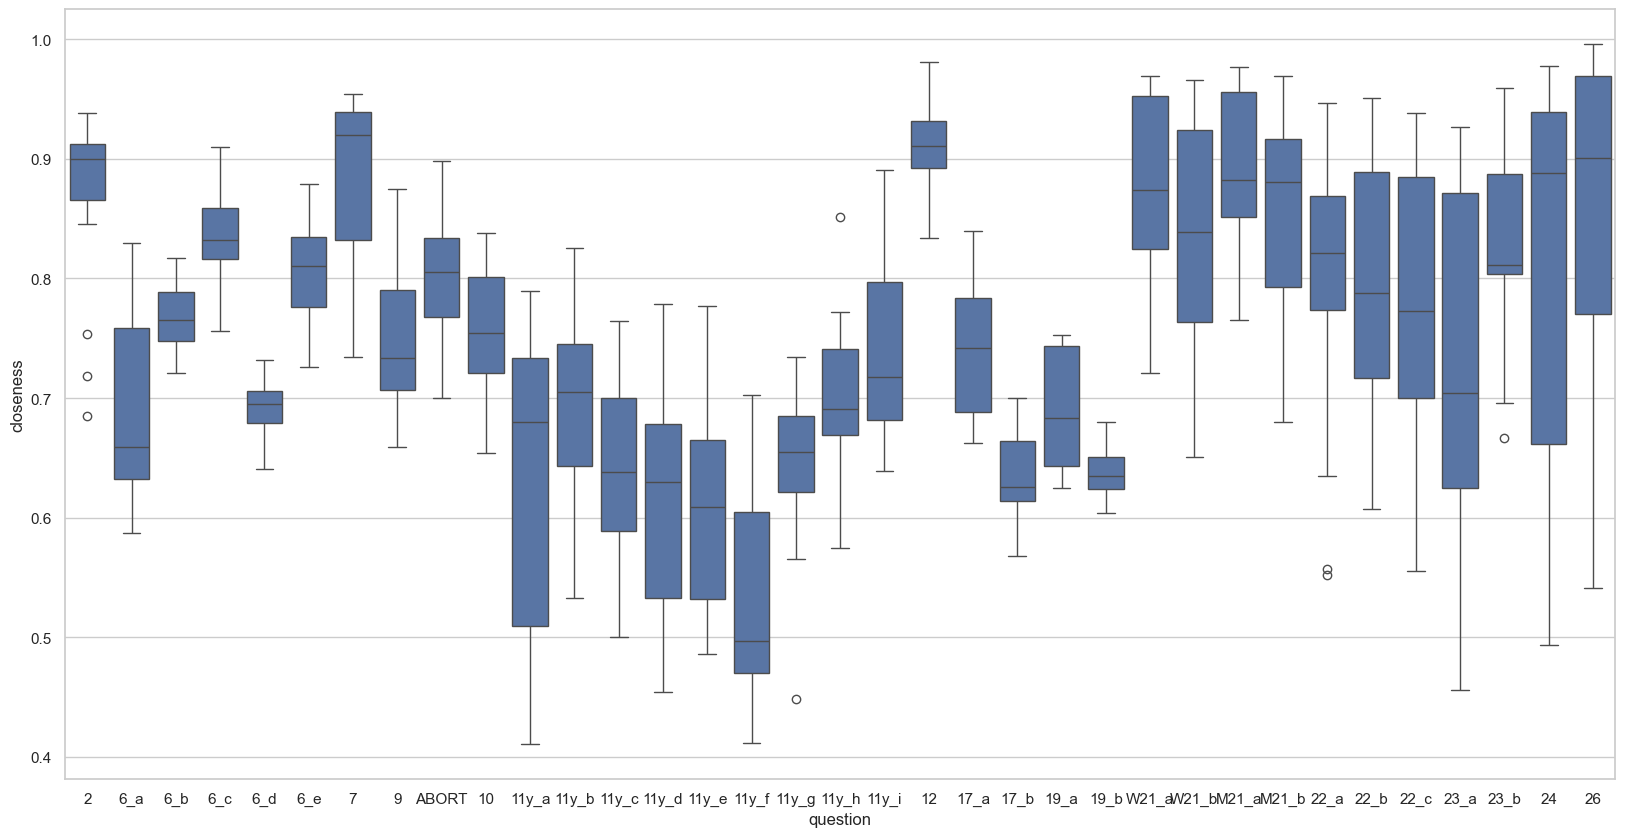

In [120]:
#Make plots to show how data varies
import seaborn as sns
sns.set_theme(style="whitegrid")
plt.figure(figsize=(20,10))
sns.boxplot(x='question',y='closeness',data=df_closeness)
plt.show()


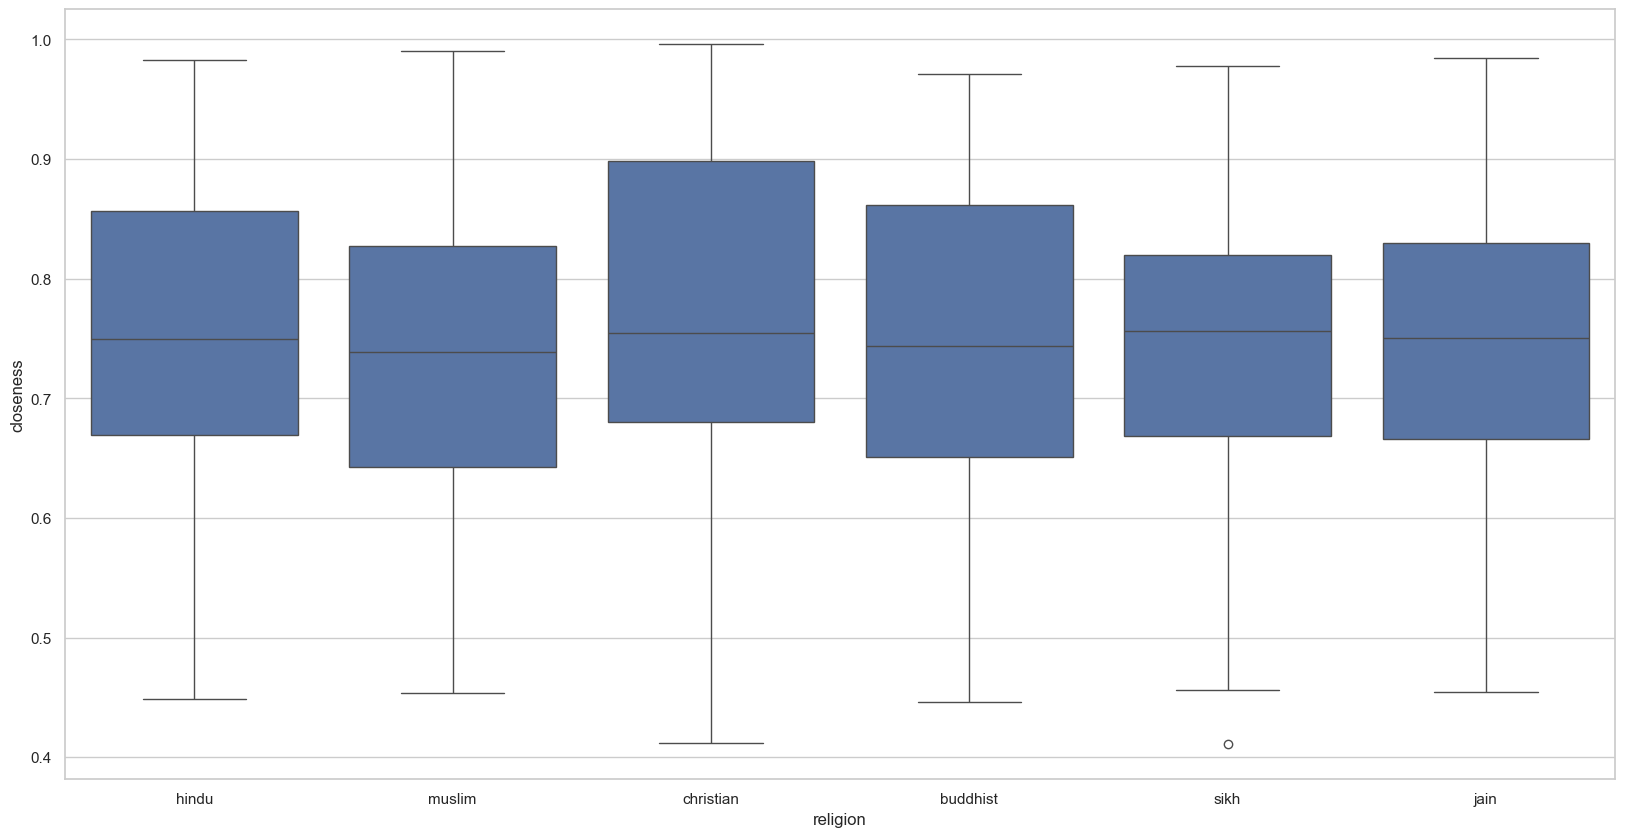

In [122]:
#Plot for each religion box plot
plt.figure(figsize=(20,10))
sns.boxplot(x='religion',y='closeness',data=df_closeness)
plt.show()


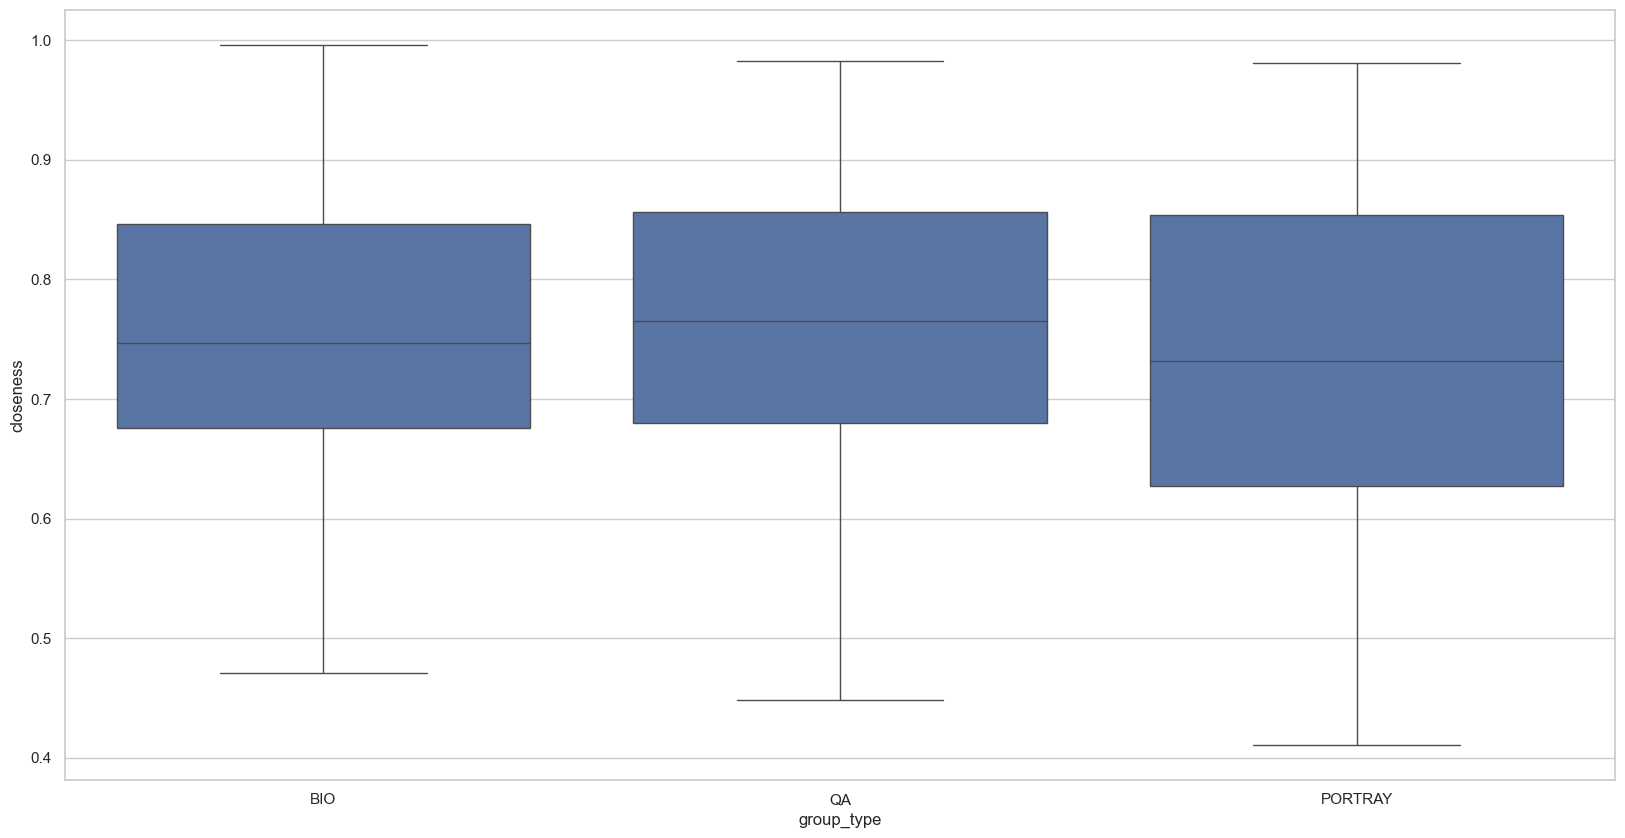

In [123]:
#Plot for each group type box plot
plt.figure(figsize=(20,10))
sns.boxplot(x='group_type',y='closeness',data=df_closeness)
plt.show()

In [124]:
df_BIO = df_closeness[df_closeness['group_type'] == 'BIO']
df_QA = df_closeness[df_closeness['group_type'] == 'QA']
df_PORTRAY = df_closeness[df_closeness['group_type'] == 'PORTRAY']

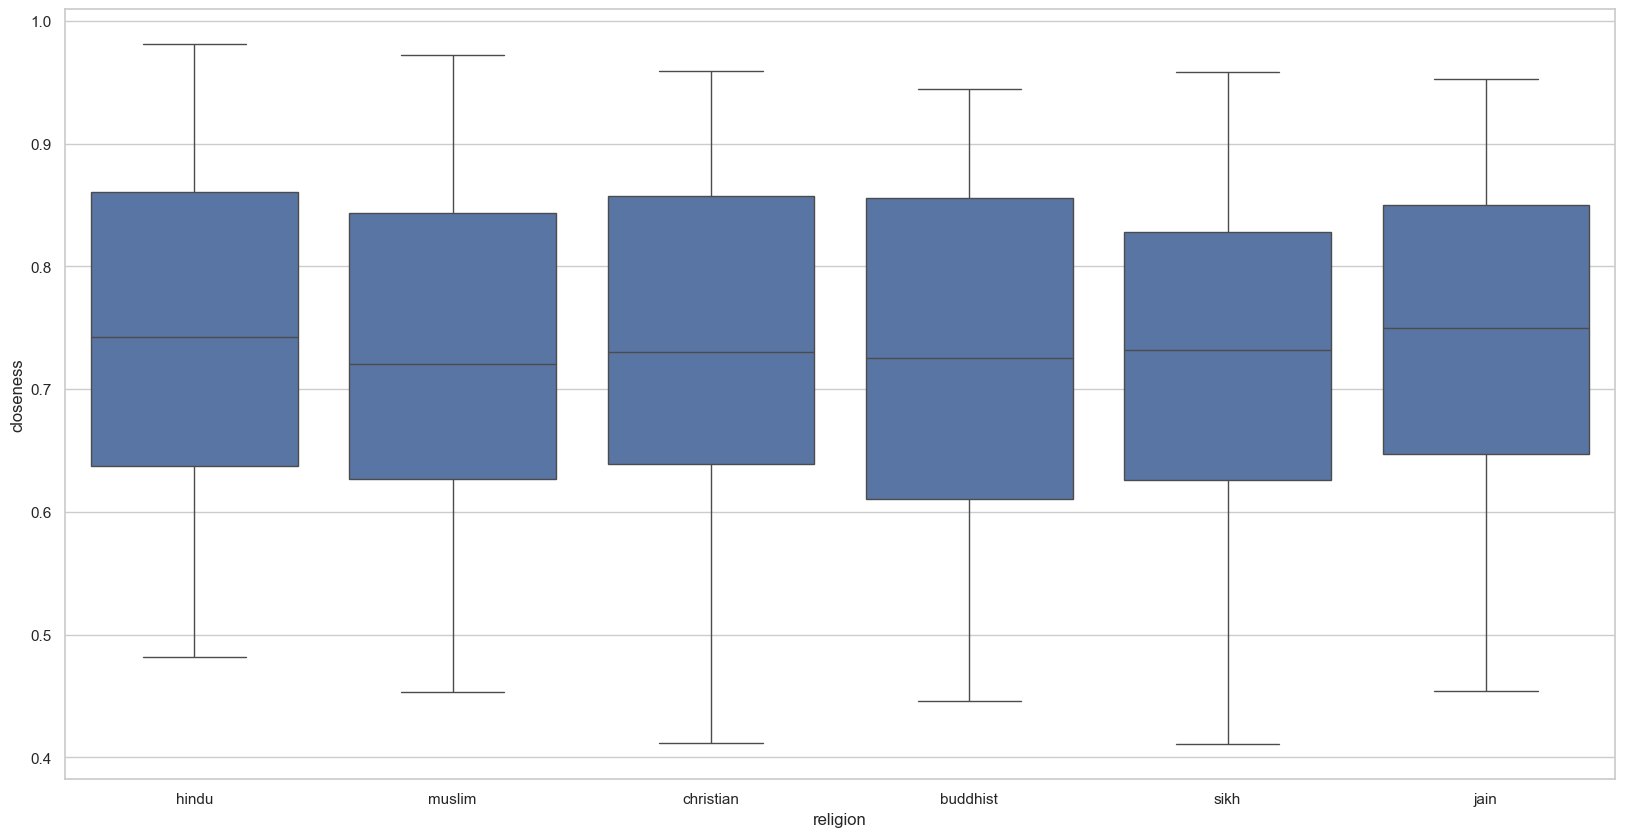

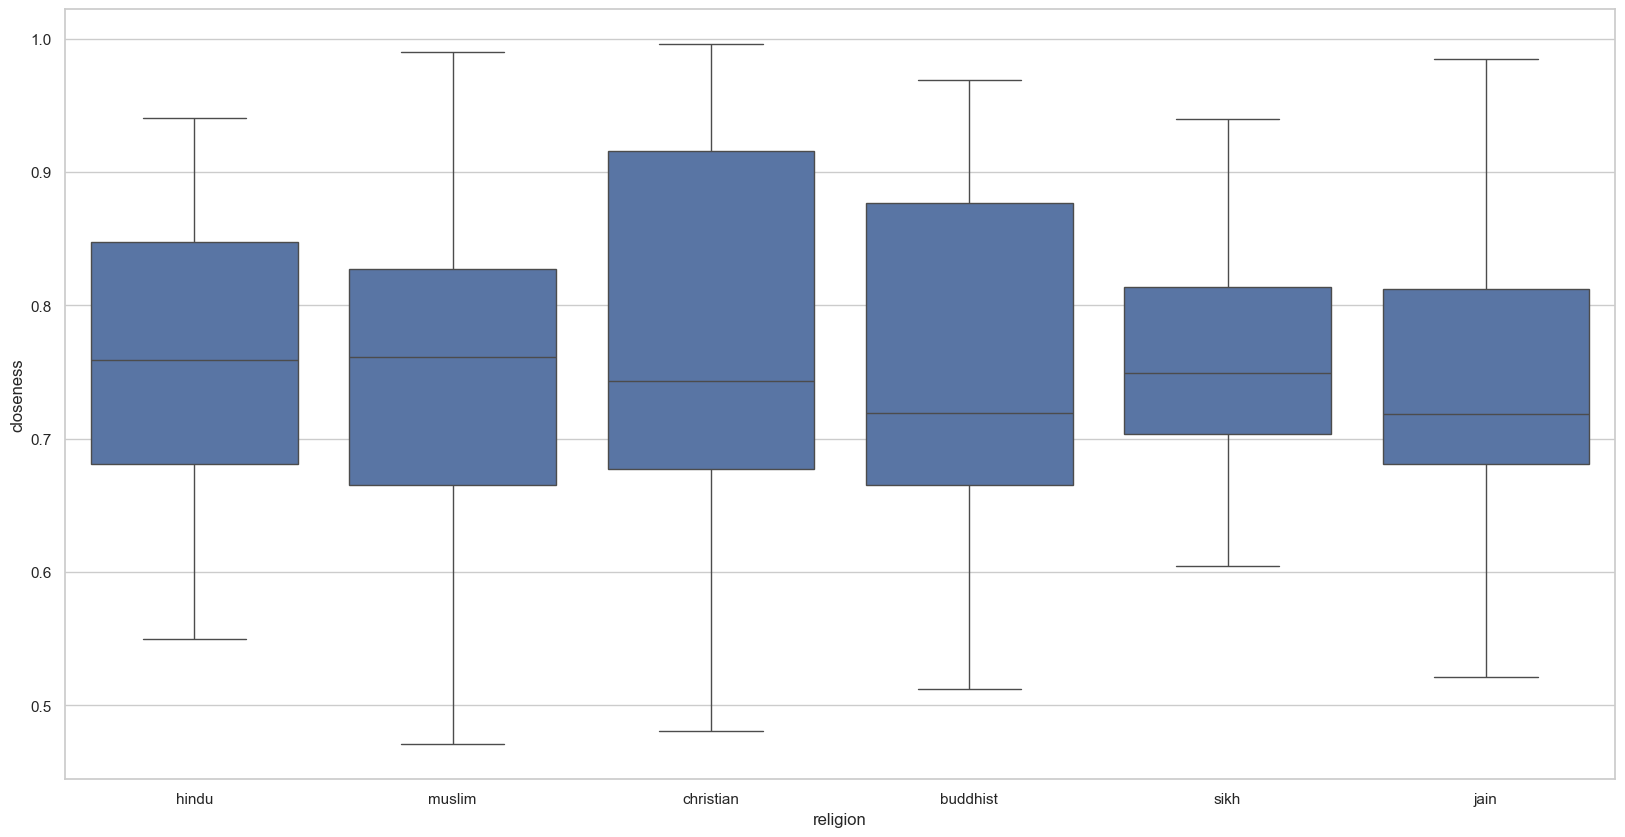

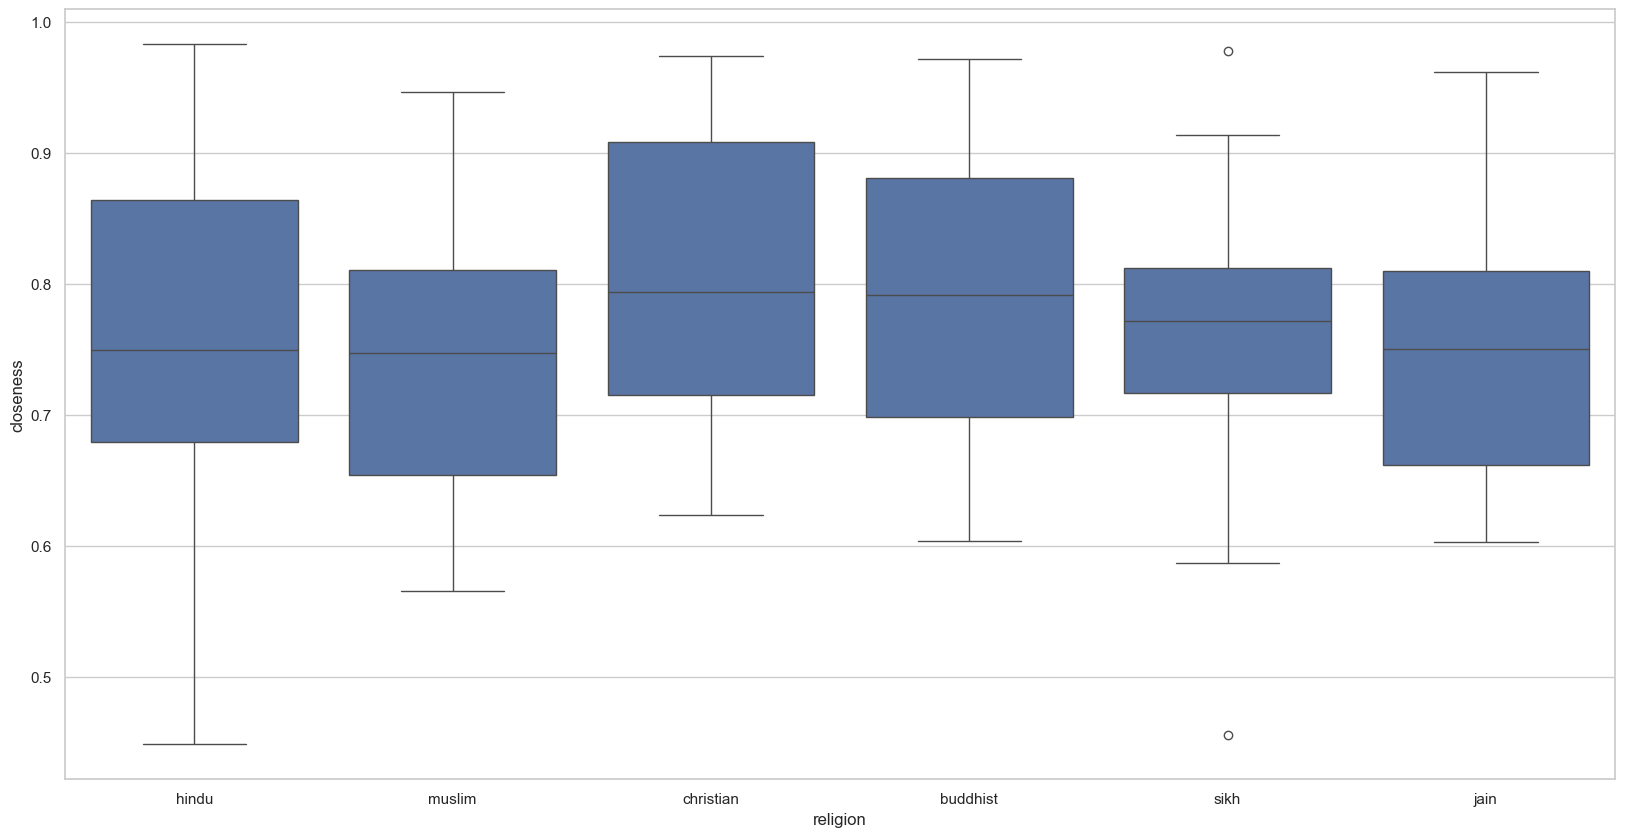

In [128]:
plt.figure(figsize=(20,10))
sns.boxplot(x='religion',y='closeness',data=df_PORTRAY)
plt.show()
plt.figure(figsize=(20,10))
sns.boxplot(x='religion',y='closeness',data=df_BIO)
plt.show()
plt.figure(figsize=(20,10))
sns.boxplot(x='religion',y='closeness',data=df_QA)
plt.show()

In [113]:
df_closeness['question'].value_counts()

2        18
11y_f    18
24       18
23_a     18
22_b     18
22_a     18
M21_a    18
W21_a    18
19_a     18
17_a     18
12       18
11y_h    18
11y_g    18
11y_e    18
6_a      18
11y_d    18
11y_c    18
11y_b    18
11y_a    18
10       18
ABORT    18
9        18
7        18
6_d      18
6_c      18
6_b      18
26       18
Name: question, dtype: int64

Now doing it without definiton

In [131]:
#Code to Process JSONL File:
import json
input_file_path = 'LLAMA3_ReligionContext.jsonl'
# Path to your output JSONL file
output_file_path = 'LLAMA3_ReligionContext_mapped.jsonl'

# Function to process the JSONL file
def process_jsonl_file(input_path, output_path, mapping):
    with open(input_path, 'r') as infile, open(output_path, 'w') as outfile:
        for line in infile:
            json_obj = json.loads(line.strip())  # Read each JSON object from the line
            old_question_number = json_obj.get("question_number")
            json_obj["question_number"] = mapping[old_question_number]  # Apply the mapping
            outfile.write(json.dumps(json_obj) + '\n')  # Write the modified object back to the file

# Run the function to process the file
process_jsonl_file(input_file_path, output_file_path, map_qno)

print(f"Processing complete. Check the output in {output_file_path}")

Processing complete. Check the output in LLAMA3_ReligionContext_mapped.jsonl


In [141]:
types_of_grouptype

['BIO', 'QA', 'PORTRAY']

In [159]:
#Create a dataframe to store the closeness values . It will have coloumns religion, question,group type and closeness
Model_Resp_Path = "LLAMA3_ReligionContext_mapped.jsonl"
df_closeness_2 = pd.DataFrame(columns = ['religion','question','group_type','closeness'])
for religion in religions:
    for question in questions:
        if question == '3rec' or question == '35' or question == '70':
            continue
        for grouptype in types_of_grouptype:
            if map_ques_no_subques[question] == '0':
                val = find_closeness_question_group(religion,question,map_no_ques,df,Model_Resp_Path,grouptype,map_qno_inv,map_religion)
                #Add line to the df using conct operation
                
                df_closeness_2 = df_closeness_2.append({'religion':religion,'question':str(question),'group_type':grouptype,'closeness':val},ignore_index = True)
            else:
                no_subq = int(map_ques_no_subques[question])
                for subq2 in range(no_subq+1):
                    
                    subq = map_to_char(subq2)
                    val = find_closeness_question_group(religion,question,map_no_ques,df,Model_Resp_Path,grouptype,map_qno_inv,map_religion,subq)
                    df_closeness_2 = df_closeness_2.append({'religion':religion,'question':str(question)+"_"+subq,'group_type':grouptype,'closeness':val},ignore_index = True)
            
df_closeness_2        
    

/var/folders/vp/c5kyxyds6jq7j8_tb4ggf_dc0000gn/T/ipykernel_1255/1669585004.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_closeness_2 = df_closeness_2.append({'religion':religion,'question':str(question),'group_type':grouptype,'closeness':val},ignore_index = True)
/var/folders/vp/c5kyxyds6jq7j8_tb4ggf_dc0000gn/T/ipykernel_1255/1669585004.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_closeness_2 = df_closeness_2.append({'religion':religion,'question':str(question),'group_type':grouptype,'closeness':val},ignore_index = True)
/var/folders/vp/c5kyxyds6jq7j8_tb4ggf_dc0000gn/T/ipykernel_1255/1669585004.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_closeness_2 = df_closeness_2.append({'religion':religi

,religion,question,group_type,closeness
0,hindu,2,BIO,0.893512
1,hindu,2,QA,0.934003
2,hindu,2,PORTRAY,0.901742
3,hindu,6_a,BIO,0.649541
4,hindu,6_b,BIO,0.776567
...,...,...,...,...
625,jain,24,QA,0.942780
626,jain,24,PORTRAY,0.655455
627,jain,26,BIO,0.975529
628,jain,26,QA,0.981483


In [151]:
df_closeness_2["closeness"].describe()

count    630.000000
mean       0.736234
std        0.138426
min        0.330126
25%        0.645826
50%        0.739157
75%        0.846191
max        0.985827
Name: closeness, dtype: float64

In [157]:
df_closeness["closeness"].describe()

count    630.000000
mean       0.736234
std        0.138426
min        0.330126
25%        0.645826
50%        0.739157
75%        0.846191
max        0.985827
Name: closeness, dtype: float64

In [161]:
df_closeness_2.to_csv('closeness_without_defn.csv')

In [162]:
merged_df = pd.merge(df_closeness, df_closeness_2, on=['religion', 'question', 'group_type'], suffixes=('_method1', '_method2'))

# Calculate the difference in closeness values
merged_df['closeness_diff'] = merged_df['closeness_method2'] - merged_df['closeness_method1']



In [163]:
method1_mean = merged_df['closeness_method1'].mean()
method2_mean = merged_df['closeness_method2'].mean()

print(f"Mean closeness for Method 1: {method1_mean}")
print(f"Mean closeness for Method 2: {method2_mean}")

Mean closeness for Method 1: 0.7522295125893534
Mean closeness for Method 2: 0.7362342708838597


In [165]:
merged_df["closeness_diff"].describe()

count    630.000000
mean      -0.015995
std        0.058810
min       -0.224825
25%       -0.051049
50%       -0.007338
75%        0.019984
max        0.175668
Name: closeness_diff, dtype: float64

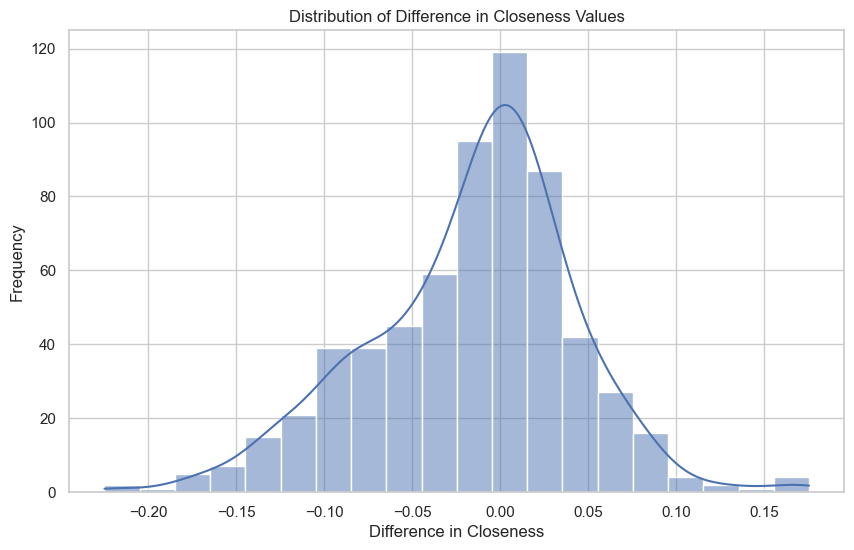

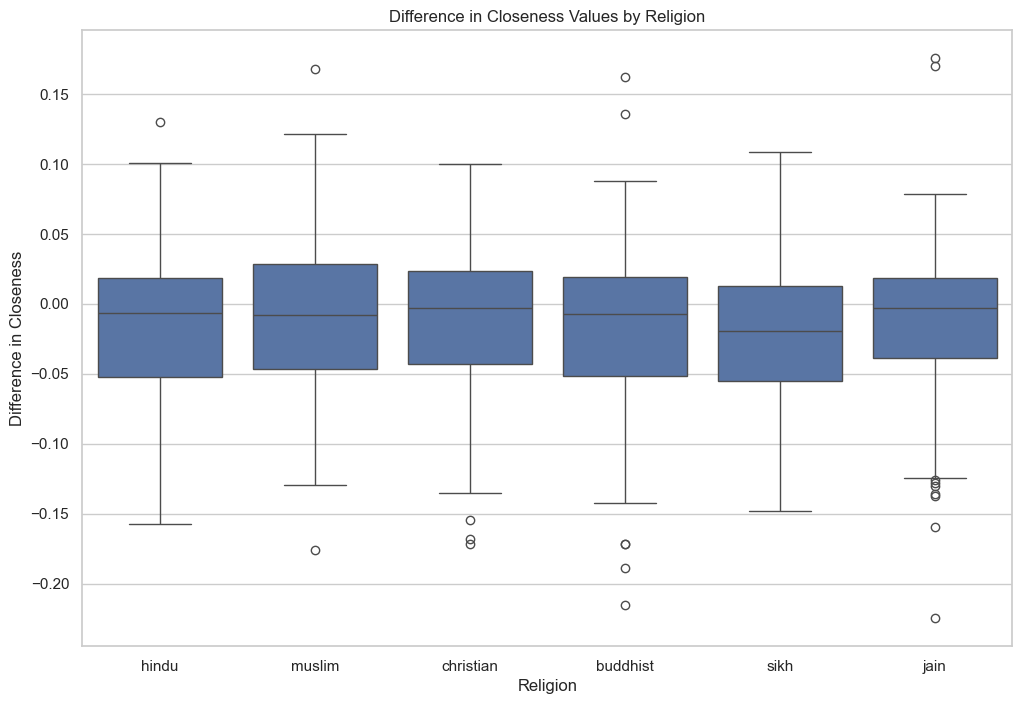

In [168]:
# Plot the distribution of the difference in closeness values
plt.figure(figsize=(10, 6))
sns.histplot(merged_df['closeness_diff'], bins=20, kde=True)
plt.title('Distribution of Difference in Closeness Values')
plt.xlabel('Difference in Closeness')
plt.ylabel('Frequency')
plt.show()
#Now I want to analyse how closeness values vary with religion

# Plot the difference in closeness values for each religion
plt.figure(figsize=(12, 8))
sns.boxplot(x='religion', y='closeness_diff', data=merged_df)
plt.title('Difference in Closeness Values by Religion')
plt.xlabel('Religion')
plt.ylabel('Difference in Closeness')
plt.show()


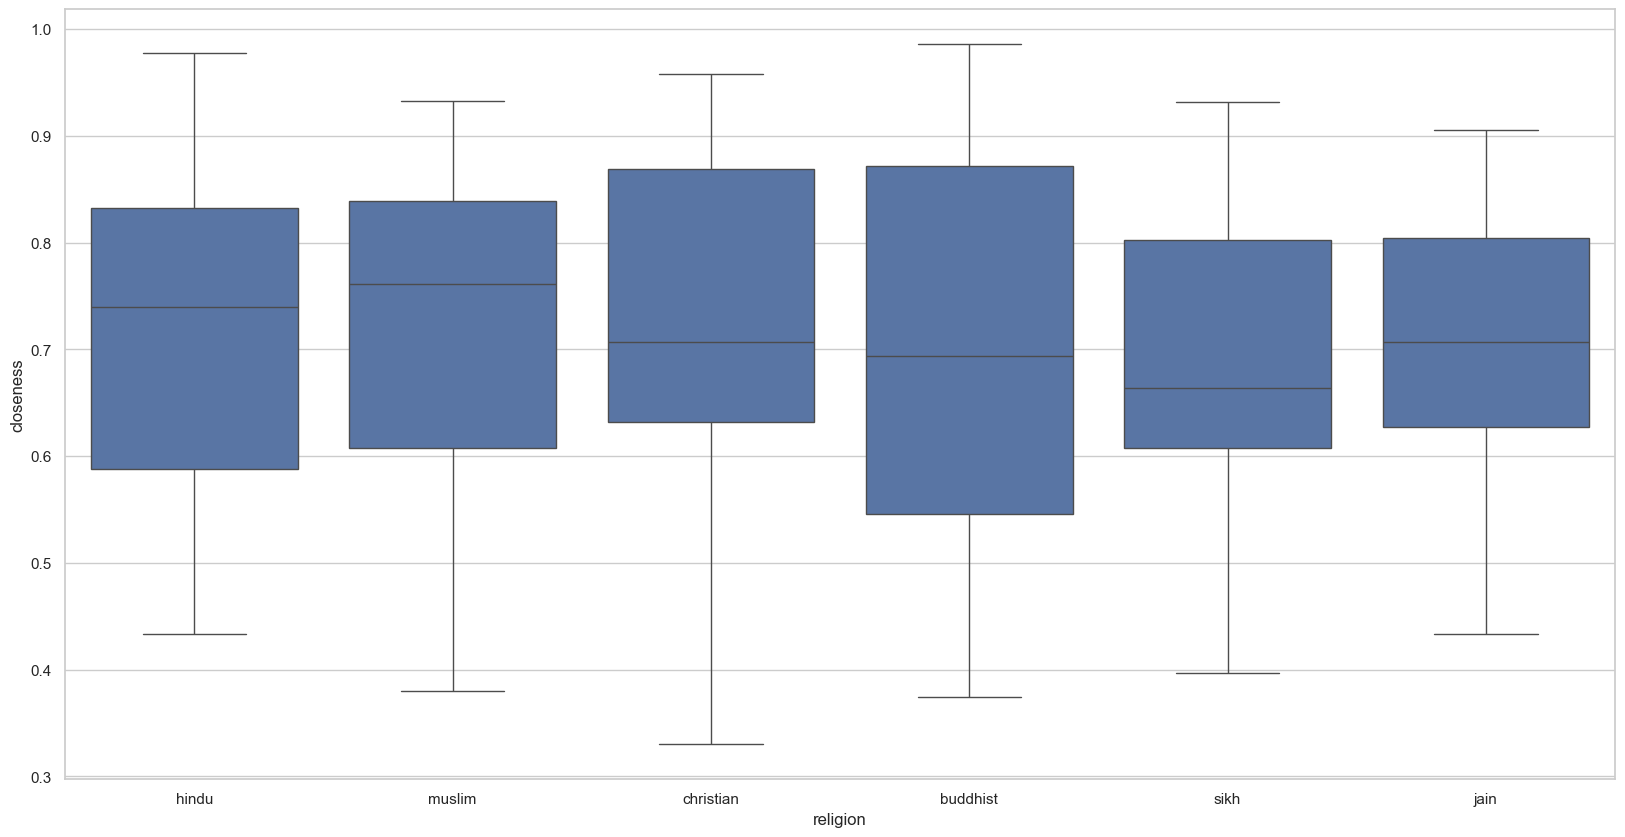

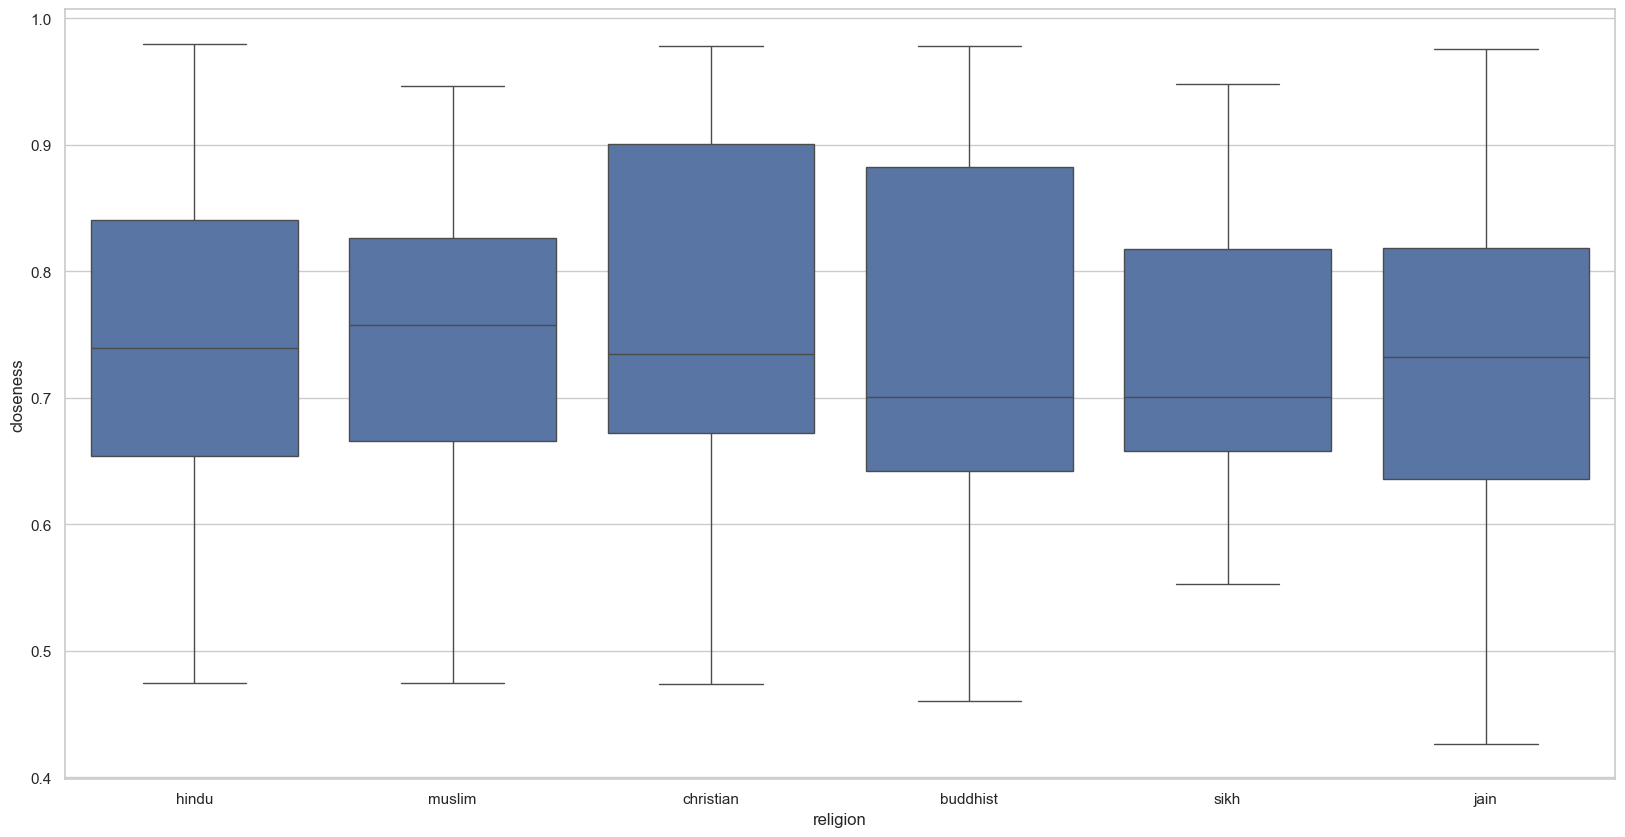

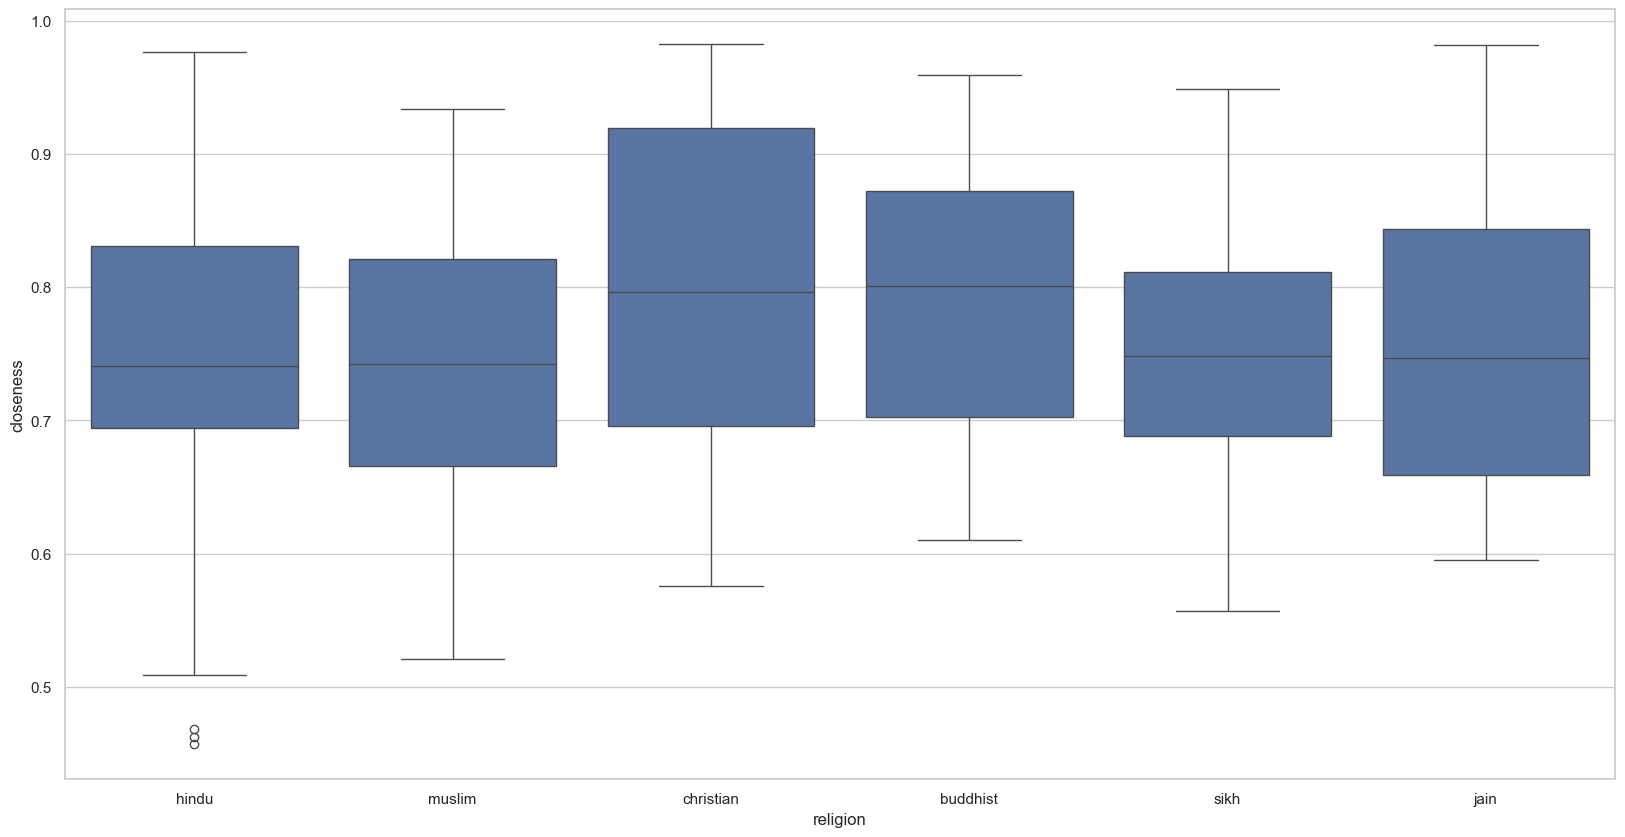

In [166]:
df_BIO_2 = df_closeness_2[df_closeness['group_type'] == 'BIO']
df_QA_2 = df_closeness_2[df_closeness['group_type'] == 'QA']
df_PORTRAY_2 = df_closeness_2[df_closeness['group_type'] == 'PORTRAY']
plt.figure(figsize=(20,10))
sns.boxplot(x='religion',y='closeness',data=df_PORTRAY_2)
plt.show()
plt.figure(figsize=(20,10))
sns.boxplot(x='religion',y='closeness',data=df_BIO_2)
plt.show()
plt.figure(figsize=(20,10))
sns.boxplot(x='religion',y='closeness',data=df_QA_2)
plt.show()